# Classification of DNA Sequences to identify invasive species with semi-supervised training

## Machine Learning at Berkeley Research Project

### Background

We attempt to solve the classification problem of identifying invasive species given binary labels and a DNA dataset from the island of Morea.

### Method

We use a semi-supervised method to take advantage of unlabeled DNA, which makes up over 80% of the dataset.

First, we load the DNA sequences and compute a similarity matrix which is easier for us to work with. We can add unlabeled data when creating this matrix, because it is not dependent on labels.

We are losing infomation about the actual DNA sequences if we do this, so we can try a different method based on reading the ATCG bases in the future (RNNs?)

Then, we can use a clustering algorithm like SVC to perform classification on the processed matrix. We are doing supervised learning, so we simply discard the unlabeled rows of our data matrix.

## Data processing 

In [1]:
# import libraries
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import sklearn as sk
from __future__ import division
from sklearn.cross_validation import train_test_split
import math

from tqdm import trange
from sklearn.svm import SVC

/Users/Tracy/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Here, we use pandas to read the excel sheet, and then extract features and convert the data to numpy arrays.

In [2]:
# read the excel sheet 
df = pd.read_excel('./BioCode for Machine Learning.xlsx')

# Read in the labels
cls = df['Classification']

# Read the DNA sequences, which are strings comprised of the letters ATCG
seq = df['Aligned Sequence']

The data we're working with are snippets of DNA a few hundred bases long.

In [3]:
seq[0]

u'ACTTTATATTTTCTATTTGGAACATGAGCTGGAATAGTAGGAACATCTCTAAGA---ATTTTAATTCGTGCAGAACTTGGACATCCA---GGAGCTTTA------ATTGGAGATGATCAAATTTATAATGTAATTGTAACAGCTCATGCTTTTGTAATAATTTTTTTTATAGTAATACCTATTATAATTGGAGGATTTGGAAATTGATTAGTTCCTTTAATACTTGGAGCTCCTGATATAGCTTTTCCTCGAATAAACAATATAAGTTTTTGATTATTACCACCTTCTTTAACTTTATTATTAGTAAGAAGAATAGTTGAAAATGGAGCAGGAACTGGTTGAACAGTTTACCCTCCTCTTTCTGCTAGAATTGCACATGGAGGTGCATCTGTTGATTTAGCTATTTTTTCTCTTCATTTAGCTGGTATATCATCAATTTTAGGAGCAGTAAATTTTATTACTACAGTAATTAATATACGATCAAATGGAATTTCATATGATCGTATACCTTTATTTGTATGATCAGTTGTAATTACAGCTTTATTATTATTATTATCTTTACCTGTATTAGCAGGAGCTATTACTATACTTTTAACAGATCGAAATCTAAATACCTCATTTTTTGATCCTGCTGGAGGAGGAGATCCTATTTTATATCAACATTTATTT--------------------------------'

We can visualize the labels below. As we can see, the labels are very messy. We can only use the values of `Indigenous`, `Invasive`, or `NaN` for supervised training. However, because most unlabeled data points still have an associated DNA sequence, we can still use them in an unsupervised pre-training stage.

In [4]:
print(cls[:20])

0     Indigenous
1     Indigenous
2              0
3            NaN
4              0
5     Indigenous
6            NaN
7            NaN
8     Indigenous
9     Indigenous
10             0
11             0
12             0
13             0
14      Invasive
15    Introduced
16    Introduced
17             0
18    Introduced
19    Introduced
Name: Classification, dtype: object


However, some species don't even have associated DNA sequences. We have to discard these before we proceed.

In [3]:
# Convert DNA data to numpy array, and convert NaNs to Nones
seq = np.array(seq.fillna('None'))

# Create a binary filter to eliminate invalid DNA sequences
valid_idx = np.array([i for i in range(len(seq)) if seq[i] != 'None'])

# Apply the filter
valid_seq = seq[valid_idx]
cls_valid = cls[valid_idx]
cls_valid = np.array(cls_valid)

Now, we process the DNA sequences by converting the string of bases into an array of characters.

In [4]:
# Seperate string into individual characters
seq_arrays = [np.array([i for i in s]) for s in valid_seq]

mat_size = len(seq_arrays)

print(len(valid_seq), len(cls_valid), mat_size)

4639 4639 4639


## Unsupervised Training

We create a similarity matrix, which is a pairwise comparison of DNA sequences and determining the percentage of base pairs that are the same.

Because the DNA sequences have been pre-aligned, we can expect this to be mostly accurate and close to the true similiarity values. In some places, the DNA sequences have a '-' character where the base was not read correctly, or missed. We ignore these.

In [5]:
sim_mat = -np.ones((mat_size, mat_size))

In [6]:
# Precomputer no dashes
dashes = []
for i in range(mat_size):
    dashes.append(seq_arrays[i] != '-')

In [7]:
# this will take a few minutes
for i in trange(mat_size):
    # clean up bad data
    a = seq_arrays[i]
    # iterate over DNA sequences and figure out the match
    for j in range(i):
        b = seq_arrays[j]
        match = (a==b)
        valid = (dashes[i] * dashes[j])
        sim_mat[i,j] = np.mean(match[valid])
        sim_mat[j,i] = sim_mat[i,j]
    sim_mat[i,i] = 1

100%|██████████| 4639/4639 [05:33<00:00, 13.92it/s]


In [8]:
valid_mat = sim_mat

In [9]:
sim_mat.shape, valid_mat.shape

((4639, 4639), (4639, 4639))

The similarity matrix is very big (100mb+), so we try PCA/SVD to extract the most useful features from the largest singular values.

In [10]:
%%time
u,s,v = np.linalg.svd(valid_mat, full_matrices=0)

CPU times: user 1min 38s, sys: 1.14 s, total: 1min 39s
Wall time: 52.4 s


The rank / number of singular values we pick is a hyperparameter. We run the dimension reduction step.

(array([  1.00000000e+00,   4.00000000e+00,   1.00000000e+01,
          3.15000000e+02,   1.64744000e+05,   2.13539440e+07,
          7.11000000e+02,   4.23000000e+02,   1.53000000e+02,
          1.60000000e+01]),
 array([-0.01478794, -0.01193264, -0.00907734, -0.00622204, -0.00336673,
        -0.00051143,  0.00234387,  0.00519918,  0.00805448,  0.01090978,
         0.01376508]),
 <a list of 10 Patch objects>)

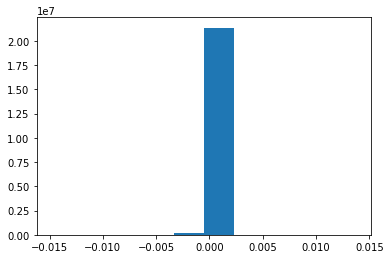

In [11]:
rank = 1000
approx_1000 = u[:,:rank].dot(np.diag(s[:rank])).dot(v[:rank])
errors = ((approx_1000 - valid_mat)/valid_mat)
plt.hist(errors.flatten())

In [12]:
approx = approx_1000

## Supervised Training

Now, we have a set of features from our pre-training step, and we're ready to run supervised training. Before we start, we need to first remove data that don't have valid labels. We can't use them anymore!

In [13]:
valid_labels = ['Introduced', 'Invasive', 'Indigenous']
labeled_cls = [label in valid_labels for label in cls_valid]

# Create a filter telling us which points are valid to use for supervised training
labeled_cls = np.array(labeled_cls)
print(len(labeled_cls))

4639


We see that 36% of the data have associated labels.

In [14]:
np.mean(labeled_cls)

0.36300926923906013

In [15]:
# apply the filter over our features and labels
supervised_X = approx[labeled_cls]
full_supervised_X = valid_mat[labeled_cls]
supervised_y = cls_valid[labeled_cls]

print(supervised_X.shape, supervised_y.shape)

(1684, 4639) (1684,)


Below, we run Support Vector Clustering (SVC). We shuffle the data first, and then split our data into testing and training splits.

There is somewhat large variance inbetween runs, so we take the average for a more accurate score.

In [17]:
# 10/18

def test_and_score(supervised_X, supervised_y, c=1e15):
    avg_score = []
    for _ in range(2):
        res_mat_shuff, cls_valid_shuff = sk.utils.shuffle(supervised_X, supervised_y, random_state=0)

        cls_train, cls_test, res_train, res_test = train_test_split(cls_valid_shuff, res_mat_shuff, test_size=0.2)

        # print(len(cls_train), len(cls_test))

        X = res_train
        y = cls_train
        X_test = res_test

        clf = SVC(C=c, kernel='poly', degree=2, coef0=0)

        clf.fit(X, y)

        predict = clf.predict(X_test)

        # print(predict == np.array(cls_test))

        score = np.mean((predict == np.array(cls_test))*1)
        avg_score.append(score)

    print(avg_score, np.mean(avg_score))

print('Approximated similarity matrix: \n')
test_and_score(supervised_X, supervised_y)
print('Full similarity matrix: \n')
test_and_score(full_supervised_X, supervised_y)

Approximated similarity matrix: 

[0.97922848664688422, 0.97032640949554894] 0.974777448071
Full similarity matrix: 

[0.96735905044510384, 0.97626112759643913] 0.971810089021


We see the results are very competitive.

Now, we use cross validation method get another take on our performance.

In [64]:
# cross validation method
# SVM

# tricks: shuffling data, cross validation, balanced classes, hyperparam tuning

def cv_test_and_score(supervised_X, supervised_y, c=1e14):
    scores = []
    param_vals = []
    
    # shuffle the data
    res_mat_shuff, cls_valid_shuff = sk.utils.shuffle(supervised_X, supervised_y, random_state=0)

    c = 10*c
    clf = SVC(C=c,kernel='poly', degree=2, coef0=0) #, gamma=i)

    score = sk.cross_validation.cross_val_score(clf, res_mat_shuff, cls_valid_shuff, cv=6) #, n_jobs=-1)
    # print('Prediction accuracy:', np.mean((prediction == np.array(cls_test))*1))
    #Coefficients used by the classifier

    scores.append(score)
    param_vals.append(i)

    print(scores)

    mn_scores = [np.mean(score) for score in scores]

    print('mean scores:', mn_scores)

print 'Approximated similarity matrix: \n'
cv_test_and_score(supervised_X, supervised_y)
print '\nFull similarity matrix: \n'
cv_test_and_score(full_supervised_X, supervised_y)

Approximated similarity matrix: 

[array([ 0.97163121,  0.97508897,  0.97508897,  0.96441281,  0.97142857,
        0.95698925])]
('mean scores:', [0.96910662862418651])

Full similarity matrix: 

[array([ 0.97163121,  0.97508897,  0.97508897,  0.96441281,  0.97142857,
        0.95698925])]
('mean scores:', [0.96910662862418651])


Notice that we included our testing data when creating the similiarity matrix, because we first create the matrix and then separate the data into train and test sets. This is somewhat unsatisfying, and very anonying if we want to do on the fly predictions. We have to recompute the simliarity matrix every time.

We now try excluding the test data from computing the similarity matrix. Instead, we can compute the values for the test data afterwards. We then also need to project the similiarity values for the test data to the SVD space, before we can run SVC.